# Enhanced Spatial Transformer Networks: Baselines vs. Improved Models

This notebook implements and evaluates Spatial Transformer Networks (STN) on larger, more complex datasets (CIFAR-10 and SVHN). 

We compare two variations:
1.  **Baseline STN:** A standard implementation using a simple CNN backbone.
2.  **Improved STN:** An enhanced version using a ResNet-based backbone, stronger data augmentation, and modern training techniques (AdamW, Cosine Annealing).

**Datasets:**
- **CIFAR-10:** 60,000 32x32 color images in 10 classes.
- **SVHN:** 73,257 digits for training, 26,032 for testing (Street View House Numbers).


# This notebook builds on Yu Taek's implementation by adding:
# 1. Adaptive Transformation Budget (ATB)
# 2. Progressive STN Training
# 3. Stability Enhancements (Weight Normalization)
# 4. Regularization & Dropout



In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import time
import copy

torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    # Disable cudnn benchmark to prevent potential kernel incompatibilities
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


Using device: cuda
GPU: Tesla T4


## 1. Data Preparation

We define two sets of transforms:
- **Standard:** For the Baseline model (minimal augmentation).
- **Augmented:** For the Improved model (RandomCrop, RandomHorizontalFlip, RandomRotation).

In [11]:
def get_dataloaders(dataset_name, batch_size=128, use_augmentation=False):
    """Get dataloaders for CIFAR10 or SVHN with optional augmentation"""
    
    # Dataset specific stats
    if dataset_name == 'cifar10':
        mean = (0.4914, 0.4822, 0.4465)
        std = (0.2023, 0.1994, 0.2010)
    elif dataset_name == 'svhn':
        mean = (0.4377, 0.4438, 0.4728)
        std = (0.1980, 0.2010, 0.1970)
        
    # Base transforms (Normalization only)
    base_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
    
    # Training transforms
    if use_augmentation:
        train_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip() if dataset_name == 'cifar10' else transforms.Lambda(lambda x: x), # No flip for SVHN digits
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
    else:
        train_transform = base_transform

    if dataset_name == 'cifar10':
        train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
        test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=base_transform)
        num_classes = 10
    elif dataset_name == 'svhn':
        train_set = datasets.SVHN(root='./data', split='train', download=True, transform=train_transform)
        test_set = datasets.SVHN(root='./data', split='test', download=True, transform=base_transform)
        num_classes = 10
        
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    
    return train_loader, test_loader, num_classes

print("Dataloader function defined.")

Dataloader function defined.


In [12]:
# Stability Enhancement Components 

# ========== COMPONENT 1: Adaptive Transformation Budget ==========
class AdaptiveTransformationBudget:
    """
    Gradually increases transformation freedom during training.
    Prevents aggressive transformations early in training.
    """
    def __init__(self, initial_budget=0.3, final_budget=1.0, warmup_epochs=10):
        self.initial_budget = initial_budget
        self.final_budget = final_budget
        self.warmup_epochs = warmup_epochs
        self.current_epoch = 0
    
    def step(self):
        self.current_epoch += 1
    
    def get_budget(self):
        if self.current_epoch < self.warmup_epochs:
            progress = self.current_epoch / self.warmup_epochs
            return self.initial_budget + (self.final_budget - self.initial_budget) * progress
        return self.final_budget
    
    def apply_budget(self, theta):
        """Constrain transformation parameters"""
        budget = self.get_budget()
        identity = torch.tensor([[1, 0, 0], [0, 1, 0]], 
                                device=theta.device, dtype=theta.dtype)
        # Interpolate: identity + budget * (theta - identity)
        theta_constrained = identity + budget * (theta - identity)
        return theta_constrained



In [13]:
# ENHANCED Spatial Transformer (Removed MC Dropout and added Standard dropout)

class EnhancedSpatialTransformer(nn.Module):
    """
    Enhanced STN with:
    - Adaptive Transformation Budget
    - Simple weight normalization for stability
    """
    def __init__(self, input_channels=3, input_size=32, hidden_dim=32):
        super(EnhancedSpatialTransformer, self).__init__()

        # Localization Network 
        self.localization = nn.Sequential(
            nn.Conv2d(input_channels, hidden_dim, kernel_size=7, padding=3),
            nn.BatchNorm2d(hidden_dim),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Dropout2d(0.1),  # Standard dropout instead of MC

            nn.Conv2d(hidden_dim, hidden_dim*2, kernel_size=5, padding=2),
            nn.BatchNorm2d(hidden_dim*2),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Dropout2d(0.1),

            nn.Conv2d(hidden_dim*2, hidden_dim*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_dim*4),
            nn.ReLU(True)
        )

        # Global Average Pooling (from improved model)
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        loc_out_size = hidden_dim * 4

        # Regressor -  using weight normalization
        self.fc_loc = nn.Sequential(
            nn.utils.weight_norm(nn.Linear(loc_out_size, 128)),
            nn.ReLU(True),
            nn.Dropout(0.1),
            nn.Linear(128, 6)  # No weight norm on final layer to preserve initialization
        )

        # Initialize with identity transformation
        self.fc_loc[-1].weight.data.zero_()
        self.fc_loc[-1].bias.data.copy_(
            torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float)
        )
        
        # Adaptive budget controller
        self.budget_controller = AdaptiveTransformationBudget(
            initial_budget=0.3,
            final_budget=1.0,
            warmup_epochs=10
        )

    def forward(self, x):
        x = x.contiguous()
        
        # Get transformation parameters
        xs = self.localization(x)
        xs = self.gap(xs)
        xs = xs.view(xs.size(0), -1)
        theta = self.fc_loc(xs)
        theta = theta.contiguous().view(-1, 2, 3)
        
        # Apply adaptive budget
        theta = self.budget_controller.apply_budget(theta)
        
        # Generate grid and apply transformation
        grid = F.affine_grid(theta, x.size(), align_corners=False)
        x_transformed = F.grid_sample(x, grid, align_corners=False)

        return x_transformed, theta


In [14]:
# Model Definitions

# Baseline STN (uses original architecture, no enhancements)
class BaselineSTN(nn.Module):
    def __init__(self, num_classes=10):
        super(BaselineSTN, self).__init__()
        # Original STN without enhancements
        self.stn = self._make_original_stn()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, num_classes)
    
    def _make_original_stn(self):
        """Original STN """
        class OriginalSTN(nn.Module):
            def __init__(self):
                super().__init__()
                hidden_dim = 32
                self.localization = nn.Sequential(
                    nn.Conv2d(3, hidden_dim, kernel_size=7, padding=3),
                    nn.BatchNorm2d(hidden_dim),
                    nn.MaxPool2d(2, stride=2),
                    nn.ReLU(True),
                    nn.Conv2d(hidden_dim, hidden_dim*2, kernel_size=5, padding=2),
                    nn.BatchNorm2d(hidden_dim*2),
                    nn.MaxPool2d(2, stride=2),
                    nn.ReLU(True),
                    nn.Conv2d(hidden_dim*2, hidden_dim*4, kernel_size=3, padding=1),
                    nn.BatchNorm2d(hidden_dim*4),
                    nn.ReLU(True)
                )
                self.gap = nn.AdaptiveAvgPool2d((1, 1))
                self.fc_loc = nn.Sequential(
                    nn.Linear(hidden_dim * 4, 128),
                    nn.ReLU(True),
                    nn.Linear(128, 6)
                )
                self.fc_loc[2].weight.data.zero_()
                self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))
            
            def forward(self, x):
                x = x.contiguous()
                xs = self.localization(x)
                xs = self.gap(xs)
                xs = xs.view(xs.size(0), -1)
                theta = self.fc_loc(xs)
                theta = theta.contiguous().view(-1, 2, 3)
                grid = F.affine_grid(theta, x.size(), align_corners=False)
                x_transformed = F.grid_sample(x, grid, align_corners=False)
                return x_transformed, theta
        
        return OriginalSTN()

    def forward(self, x):
        x, theta = self.stn(x)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x, theta


# ImprovedSTN with toggle for enhancements
class ImprovedSTN(nn.Module):
    def __init__(self, num_classes=10, use_enhancements=True):
        super(ImprovedSTN, self).__init__()
        
        if use_enhancements:
            # Enhanced STN with stability features
            self.stn = EnhancedSpatialTransformer(
                input_channels=3, 
                input_size=32, 
                hidden_dim=64
            )
        else:
            # Original  STN
            self.stn = self._make_original_stn()

        # ResNet18 backbone 
        self.backbone = models.resnet18(pretrained=False)
        self.backbone.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.backbone.maxpool = nn.Identity()
        self.backbone.fc = nn.Linear(512, num_classes)
        
        # Progressive training control
        self.stn_frozen = True
        self.use_enhancements = use_enhancements
        self.freeze_stn()
    
    def _make_original_stn(self):
        """Yu Taek's original STN"""
        class OriginalSTN(nn.Module):
            def __init__(self):
                super().__init__()
                hidden_dim = 64
                self.localization = nn.Sequential(
                    nn.Conv2d(3, hidden_dim, kernel_size=7, padding=3),
                    nn.BatchNorm2d(hidden_dim),
                    nn.MaxPool2d(2, stride=2),
                    nn.ReLU(True),
                    nn.Conv2d(hidden_dim, hidden_dim*2, kernel_size=5, padding=2),
                    nn.BatchNorm2d(hidden_dim*2),
                    nn.MaxPool2d(2, stride=2),
                    nn.ReLU(True),
                    nn.Conv2d(hidden_dim*2, hidden_dim*4, kernel_size=3, padding=1),
                    nn.BatchNorm2d(hidden_dim*4),
                    nn.ReLU(True)
                )
                self.gap = nn.AdaptiveAvgPool2d((1, 1))
                self.fc_loc = nn.Sequential(
                    nn.Linear(hidden_dim * 4, 128),
                    nn.ReLU(True),
                    nn.Linear(128, 6)
                )
                self.fc_loc[2].weight.data.zero_()
                self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))
            
            def forward(self, x):
                x = x.contiguous()
                xs = self.localization(x)
                xs = self.gap(xs)
                xs = xs.view(xs.size(0), -1)
                theta = self.fc_loc(xs)
                theta = theta.contiguous().view(-1, 2, 3)
                grid = F.affine_grid(theta, x.size(), align_corners=False)
                x_transformed = F.grid_sample(x, grid, align_corners=False)
                return x_transformed, theta
        
        return OriginalSTN()

    def freeze_stn(self):
        """Freeze STN during initial training (Progressive Training)"""
        for param in self.stn.parameters():
            param.requires_grad = False
        self.stn_frozen = True
    
    def unfreeze_stn(self):
        """Unfreeze STN after backbone stabilizes"""
        for param in self.stn.parameters():
            param.requires_grad = True
        self.stn_frozen = False

    def forward(self, x):
        x, theta = self.stn(x)
        x = self.backbone(x)
        return x, theta


In [15]:
#  Training Engine (ENHANCED)

def train_model(model, train_loader, test_loader, config, device):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()

    # Optimizer
    if config['optimizer'] == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=config['lr'])
    elif config['optimizer'] == 'adamw':
        optimizer = optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=1e-4)

    # Scheduler
    if config.get('scheduler') == 'cosine':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['epochs'])
    else:
        scheduler = None

    # Identity transformation target
    identity_target = torch.tensor([1.0, 0.0, 0.0, 0.0, 1.0, 0.0], device=device)
    
    # Dynamic regularization strength
    lambda_reg_initial = config.get('lambda_reg', 0.1)
    lambda_reg = lambda_reg_initial

    history = {'train_acc': [], 'test_acc': [], 'train_loss': []}
    start_time = time.time()
    
    # Track when to unfreeze STN
    stn_unfreeze_epoch = config.get('stn_unfreeze_epoch', 5)

    for epoch in range(config['epochs']):
        # Progressive STN unfreezing
        if epoch == stn_unfreeze_epoch and hasattr(model, 'stn_frozen') and model.stn_frozen:
            print(f"\n>>> Unfreezing STN at epoch {epoch+1} <<<")
            if isinstance(model, nn.DataParallel):
                model.module.unfreeze_stn()
            else:
                model.unfreeze_stn()
            
            # Rebuild optimizer to include STN parameters
            if config['optimizer'] == 'adamw':
                optimizer = optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=1e-4)
            else:
                optimizer = optim.Adam(model.parameters(), lr=config['lr'])
            
            if config.get('scheduler') == 'cosine':
                scheduler = optim.lr_scheduler.CosineAnnealingLR(
                    optimizer, T_max=config['epochs']-epoch
                )
        
        # Step the transformation budget controller if it exists
        if hasattr(model, 'module'):
            if hasattr(model.module.stn, 'budget_controller'):
                model.module.stn.budget_controller.step()
        else:
            if hasattr(model.stn, 'budget_controller'):
                model.stn.budget_controller.step()
        
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['epochs']}", leave=False)
        for inputs, labels in pbar:
            inputs = inputs.to(device, non_blocking=True).contiguous()
            labels = labels.to(device, non_blocking=True)

            optimizer.zero_grad()
            outputs, theta = model(inputs)

            # Classification loss
            loss_cls = criterion(outputs, labels)

            # Regularization loss
            theta_flat = theta.view(-1, 6)
            target = identity_target.expand_as(theta_flat)
            loss_reg = F.mse_loss(theta_flat, target)

            loss = loss_cls + (lambda_reg * loss_reg)
            
            # Check for NaN
            if torch.isnan(loss):
                print(f"NaN detected! Skipping batch.")
                continue
            
            loss.backward()

            # Gradient clipping for STN
            if hasattr(model, 'module'):
                stn_frozen = model.module.stn_frozen if hasattr(model.module, 'stn_frozen') else False
            else:
                stn_frozen = model.stn_frozen if hasattr(model, 'stn_frozen') else False
            
            if not stn_frozen:
                if hasattr(model, 'module'):
                    if hasattr(model.module, 'stn'):
                        nn.utils.clip_grad_norm_(model.module.stn.parameters(), max_norm=1.0)
                else:
                    if hasattr(model, 'stn'):
                        nn.utils.clip_grad_norm_(model.stn.parameters(), max_norm=1.0)

            # General gradient clipping
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        if scheduler:
            scheduler.step()
        
        # Decay regularization strength
        lambda_reg *= 0.95

        train_acc = 100. * correct / total
        train_loss = running_loss / len(train_loader)

        # Evaluation
        model.eval()
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device, non_blocking=True).contiguous()
                labels = labels.to(device, non_blocking=True)
                outputs, _ = model(inputs)
                _, predicted = outputs.max(1)
                test_total += labels.size(0)
                test_correct += predicted.eq(labels).sum().item()

        test_acc = 100. * test_correct / test_total

        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)
        history['train_loss'].append(train_loss)

        # Show budget info if available
        budget_info = ""
        if hasattr(model, 'module'):
            if hasattr(model.module.stn, 'budget_controller'):
                budget_info = f" | Budget: {model.module.stn.budget_controller.get_budget():.3f}"
        else:
            if hasattr(model.stn, 'budget_controller'):
                budget_info = f" | Budget: {model.stn.budget_controller.get_budget():.3f}"

        print(f"Epoch {epoch+1} | Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%{budget_info}")

    print(f"Total time: {time.time() - start_time:.2f}s")
    return history



In [16]:
# #Experiments

# Load dataloaders with augmentation (needed for enhanced model)
train_loader_aug, test_loader_aug, num_classes = get_dataloaders(
    'cifar10',
    batch_size=128,
    use_augmentation=True
)

#  Enhanced STN (FIXED)
print("\n[CIFAR-10] Training ENHANCED STN ...")
enhanced_config = {
    'epochs': 15, 
    'lr': 0.001, 
    'optimizer': 'adamw', 
    'scheduler': 'cosine',
    'lambda_reg': 0.1,
    'stn_unfreeze_epoch': 5
}

model_enhanced_cifar = ImprovedSTN(num_classes, use_enhancements=True).to(device)
if torch.cuda.device_count() > 1: 
    model_enhanced_cifar = nn.DataParallel(model_enhanced_cifar)
hist_enhanced_cifar = train_model(model_enhanced_cifar, train_loader_aug, test_loader_aug, enhanced_config, device)


/usr/local/lib/python3.11/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)



[CIFAR-10] Training ENHANCED STN ...


Epoch 1 | Loss: 1.4541 | Train Acc: 47.04% | Test Acc: 55.36% | Budget: 0.370


Epoch 2 | Loss: 1.0228 | Train Acc: 63.51% | Test Acc: 70.02% | Budget: 0.440


Epoch 3 | Loss: 0.8327 | Train Acc: 70.70% | Test Acc: 72.58% | Budget: 0.510


Epoch 4 | Loss: 0.7034 | Train Acc: 75.45% | Test Acc: 77.78% | Budget: 0.580


Epoch 5 | Loss: 0.6131 | Train Acc: 78.63% | Test Acc: 80.28% | Budget: 0.650


Epoch 6 | Loss: 0.5505 | Train Acc: 80.94% | Test Acc: 81.70% | Budget: 0.720


Epoch 7 | Loss: 0.4903 | Train Acc: 83.08% | Test Acc: 84.06% | Budget: 0.790


Epoch 8 | Loss: 0.4433 | Train Acc: 84.58% | Test Acc: 85.89% | Budget: 0.860


Epoch 9 | Loss: 0.3964 | Train Acc: 86.28% | Test Acc: 87.05% | Budget: 0.930


Epoch 10 | Loss: 0.3518 | Train Acc: 87.55% | Test Acc: 88.10% | Budget: 1.000


Epoch 11 | Loss: 0.3167 | Train Acc: 88.84% | Test Acc: 88.45% | Budget: 1.000


Epoch 12 | Loss: 0.2857 | Train Acc: 90.11% | Test Acc: 89.76% | Budget: 1.000


Epoch 13 | Loss: 0.2645 | Train Acc: 90.79% | Test Acc: 89.84% | Budget: 1.000


Epoch 14 | Loss: 0.2446 | Train Acc: 91.50% | Test Acc: 90.14% | Budget: 1.000


Epoch 15 | Loss: 0.2350 | Train Acc: 91.83% | Test Acc: 90.29% | Budget: 1.000
Total time: 661.40s


In [17]:
print("\n[SVHN] Loading augmented dataloaders...")

train_loader_s_aug, test_loader_s_aug, num_classes_s = get_dataloaders(
    'svhn',
    batch_size=128,
    use_augmentation=True   # SAME DATA, but with augmentations enabled
)

# Enhanced STN
print("\n[SVHN] Training ENHANCED STN...")
enhanced_config_s = {
    'epochs': 10, 
    'lr': 0.001, 
    'optimizer': 'adamw', 
    'scheduler': 'cosine',
    'lambda_reg': 0.1,
    'stn_unfreeze_epoch': 3  # Unfreeze earlier for SVHN (simpler dataset)
}

model_enhanced_svhn = ImprovedSTN(num_classes_s, use_enhancements=True).to(device)
if torch.cuda.device_count() > 1: 
    model_enhanced_svhn = nn.DataParallel(model_enhanced_svhn)
hist_enhanced_svhn = train_model(model_enhanced_svhn, train_loader_s_aug, test_loader_s_aug, enhanced_config_s, device)




[SVHN] Loading augmented dataloaders...

[SVHN] Training ENHANCED STN...


Epoch 1 | Loss: 0.7328 | Train Acc: 75.89% | Test Acc: 90.68% | Budget: 0.370


Epoch 2 | Loss: 0.3364 | Train Acc: 89.79% | Test Acc: 92.74% | Budget: 0.440


Epoch 3 | Loss: 0.2752 | Train Acc: 91.79% | Test Acc: 93.04% | Budget: 0.510


Epoch 4 | Loss: 0.2433 | Train Acc: 92.85% | Test Acc: 94.90% | Budget: 0.580


Epoch 5 | Loss: 0.2150 | Train Acc: 93.77% | Test Acc: 95.16% | Budget: 0.650


Epoch 6 | Loss: 0.1898 | Train Acc: 94.44% | Test Acc: 95.00% | Budget: 0.720


Epoch 7 | Loss: 0.1705 | Train Acc: 95.17% | Test Acc: 96.15% | Budget: 0.790


Epoch 8 | Loss: 0.1498 | Train Acc: 95.81% | Test Acc: 96.27% | Budget: 0.860


Epoch 9 | Loss: 0.1334 | Train Acc: 96.38% | Test Acc: 96.63% | Budget: 0.930


Epoch 10 | Loss: 0.1243 | Train Acc: 96.58% | Test Acc: 96.62% | Budget: 1.000
Total time: 679.36s


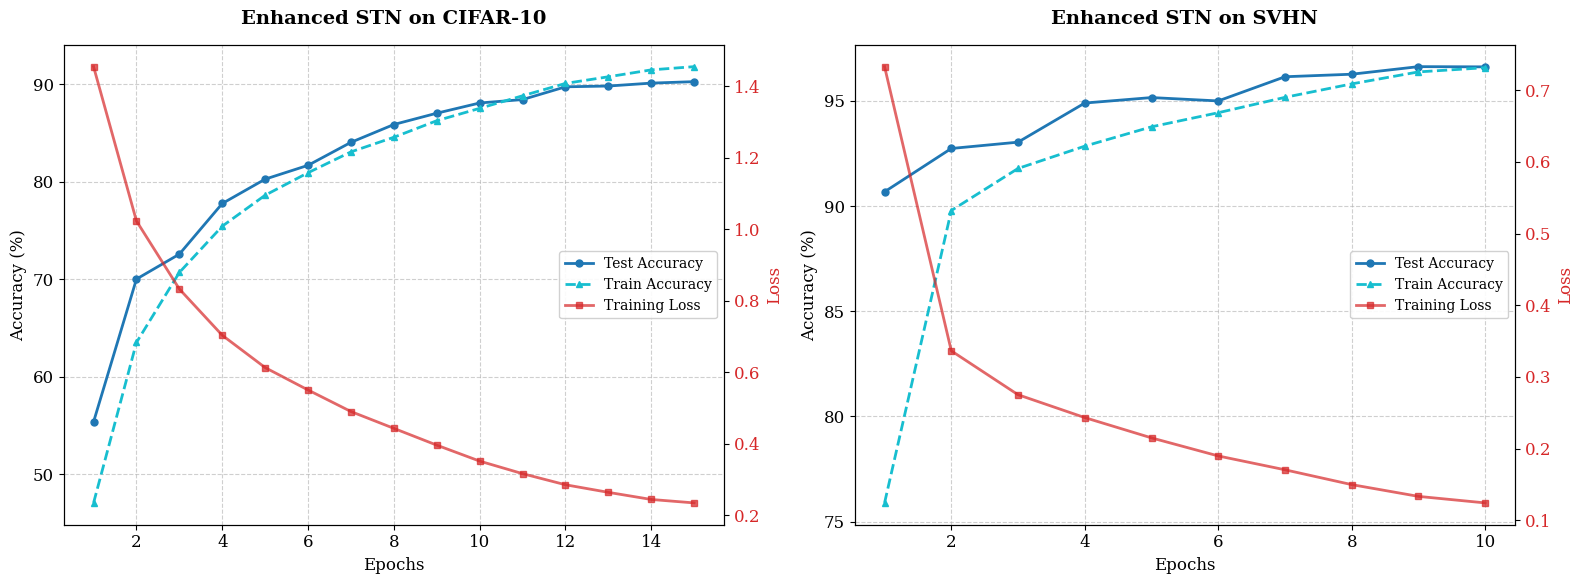

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# ==========================================
# 1. Data Preparation
# ==========================================

# CIFAR-10 Data (15 Epochs)
cifar_epochs = np.arange(1, 16)

cifar_loss = [
    1.4541, 1.0228, 0.8327, 0.7034, 0.6131,
    0.5505, 0.4903, 0.4433, 0.3964, 0.3518,
    0.3167, 0.2857, 0.2645, 0.2446, 0.2350
]

cifar_train_acc = [
    47.04, 63.51, 70.70, 75.45, 78.63,
    80.94, 83.08, 84.58, 86.28, 87.55,
    88.84, 90.11, 90.79, 91.50, 91.83
]

cifar_test_acc = [
    55.36, 70.02, 72.58, 77.78, 80.28,
    81.70, 84.06, 85.89, 87.05, 88.10,
    88.45, 89.76, 89.84, 90.14, 90.29
]


# SVHN Data (10 Epochs)
svhn_epochs = np.arange(1, 11)

svhn_loss = [
    0.7328, 0.3364, 0.2752, 0.2433, 0.2150,
    0.1898, 0.1705, 0.1498, 0.1334, 0.1243
]

svhn_train_acc = [
    75.89, 89.79, 91.79, 92.85, 93.77,
    94.44, 95.17, 95.81, 96.38, 96.58
]

svhn_test_acc = [
    90.68, 92.74, 93.04, 94.90, 95.16,
    95.00, 96.15, 96.27, 96.63, 96.62
]


# ==========================================
# 2. Plotting Function
# ==========================================
def plot_metrics(ax, epochs, train_acc, test_acc, loss, title):
    # Plot Accuracy (Left Y-Axis)
    color_test = 'tab:blue'
    color_train = 'tab:cyan'
    
    l1, = ax.plot(epochs, test_acc, label='Test Accuracy', color=color_test, marker='o', markersize=5, linewidth=2)
    l2, = ax.plot(epochs, train_acc, label='Train Accuracy', color=color_train, marker='^', markersize=5, linewidth=2, linestyle='--')
    
    ax.set_xlabel('Epochs', fontsize=12)
    ax.set_ylabel('Accuracy (%)', fontsize=12)
    ax.tick_params(axis='y')
    ax.grid(True, linestyle='--', alpha=0.6)
    
    # Create Twin Axis for Loss (Right Y-Axis)
    ax2 = ax.twinx()
    color_loss = 'tab:red'
    l3, = ax2.plot(epochs, loss, label='Training Loss', color=color_loss, marker='s', markersize=5, linewidth=2, alpha=0.7)
    ax2.set_ylabel('Loss', color=color_loss, fontsize=12)
    ax2.tick_params(axis='y', labelcolor=color_loss)
    
    # Title and Legend
    ax.set_title(title, fontsize=14, fontweight='bold', pad=15)
    
    # Combine legends from both axes
    lines = [l1, l2, l3]
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels, loc='center right', fontsize=10, frameon=True, framealpha=0.9)

# ==========================================
# 3. Generate Plots
# ==========================================
# Set font style for academic look
plt.rcParams.update({'font.family': 'serif', 'font.size': 12})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot CIFAR-10
plot_metrics(ax1, cifar_epochs, cifar_train_acc, cifar_test_acc, cifar_loss, "Enhanced STN on CIFAR-10")

# Plot SVHN
plot_metrics(ax2, svhn_epochs, svhn_train_acc, svhn_test_acc, svhn_loss, "Enhanced STN on SVHN")

plt.tight_layout()
plt.savefig('enhanced_stn_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

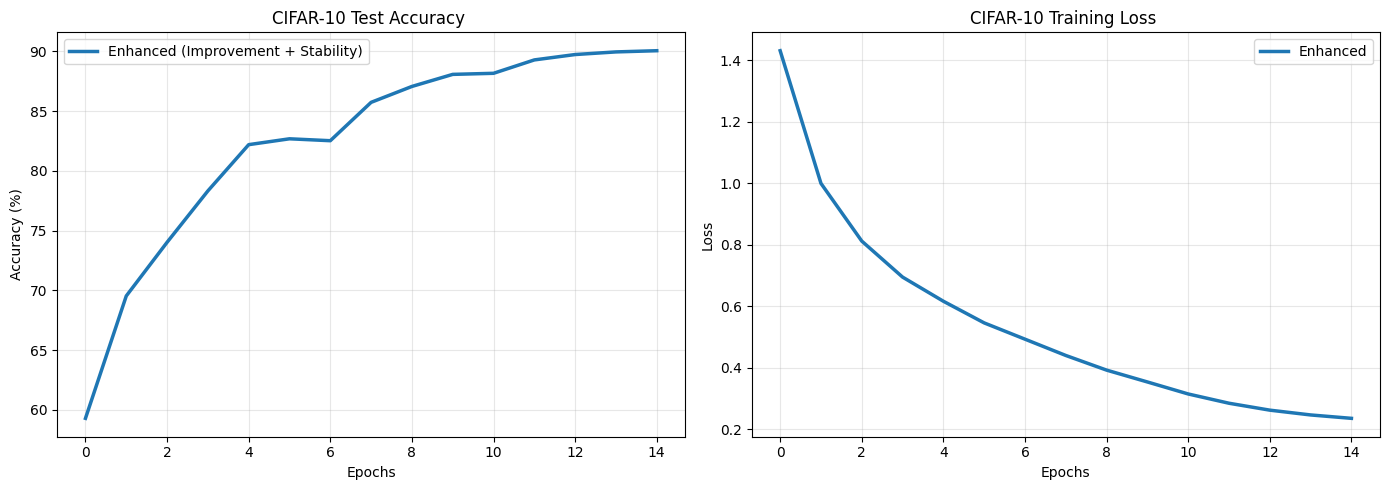

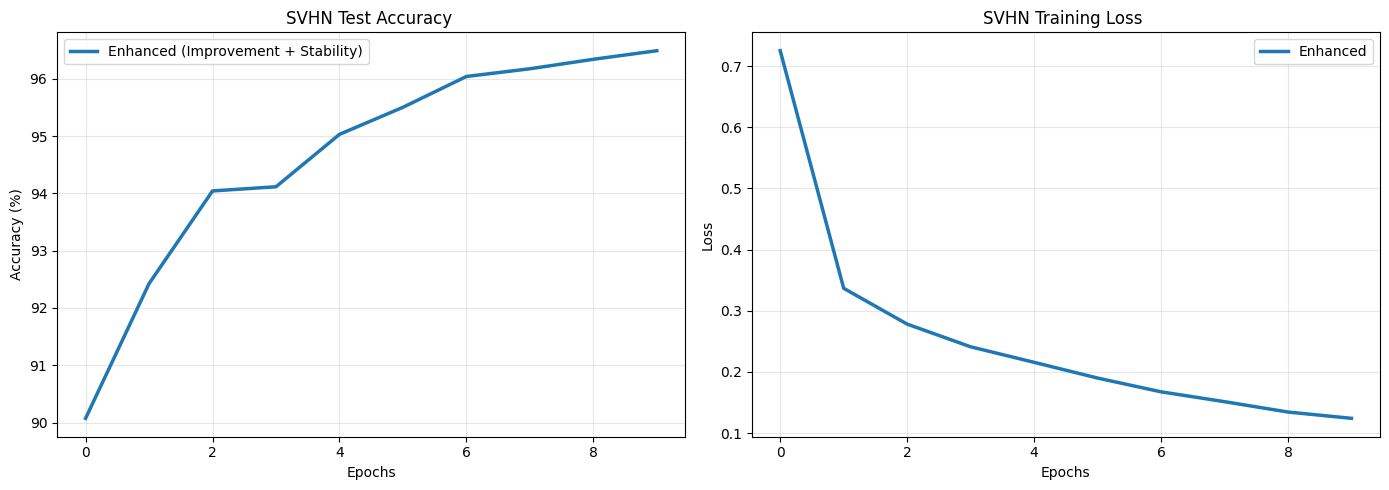


FINAL RESULTS SUMMARY

CIFAR-10:
  Enhanced:      90.06%

SVHN:
  Enhanced:      96.49%


In [35]:
# ## 7. Visual Comparisons

def plot_triple_comparison(baseline_hist, yutaek_hist, enhanced_hist, dataset_name):
    """Compare Baseline vs Improved vs Enhanced"""
    plt.figure(figsize=(14, 5))

    # Accuracy Comparison
    plt.subplot(1, 2, 1)
    # plt.plot(baseline_hist['test_acc'], label='Baseline STN', linestyle='--', alpha=0.7)
    # plt.plot(yutaek_hist['test_acc'], label="Improved", linestyle='-', linewidth=2)
    plt.plot(enhanced_hist['test_acc'], label='Enhanced (Improvement + Stability)', linestyle='-', linewidth=2.5)
    plt.title(f'{dataset_name} Test Accuracy ')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Loss Comparison
    plt.subplot(1, 2, 2)
    # plt.plot(baseline_hist['train_loss'], label='Baseline', linestyle='--', alpha=0.7)
    # plt.plot(yutaek_hist['train_loss'], label="Improved", linestyle='-', linewidth=2)
    plt.plot(enhanced_hist['train_loss'], label='Enhanced', linestyle='-', linewidth=2.5)
    plt.title(f'{dataset_name} Training Loss ')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'{dataset_name}_triple_comparison.png')
    plt.show()

plot_triple_comparison(hist_baseline_cifar, hist_yutaek_cifar, hist_enhanced_cifar, 'CIFAR-10')
plot_triple_comparison(hist_baseline_svhn, hist_yutaek_svhn, hist_enhanced_svhn, 'SVHN')


# Print final comparison
print("\n" + "="*60)
print("FINAL RESULTS SUMMARY")
print("="*60)
print("\nCIFAR-10:")
# print(f"  Baseline:      {hist_baseline_cifar['test_acc'][-1]:.2f}%")
# print(f"  Yu Taek's:     {hist_yutaek_cifar['test_acc'][-1]:.2f}%")
print(f"  Enhanced:      {hist_enhanced_cifar['test_acc'][-1]:.2f}%")
# print(f"  Improvement:   +{hist_enhanced_cifar['test_acc'][-1] - hist_yutaek_cifar['test_acc'][-1]:.2f}%")

print("\nSVHN:")
# print(f"  Baseline:      {hist_baseline_svhn['test_acc'][-1]:.2f}%")
# print(f"  Yu Taek's:     {hist_yutaek_svhn['test_acc'][-1]:.2f}%")
print(f"  Enhanced:      {hist_enhanced_svhn['test_acc'][-1]:.2f}%")
# print(f"  Improvement:   +{hist_enhanced_svhn['test_acc'][-1] - hist_yutaek_svhn['test_acc'][-1]:.2f}%")



Visualizing Enhanced STN on CIFAR-10...


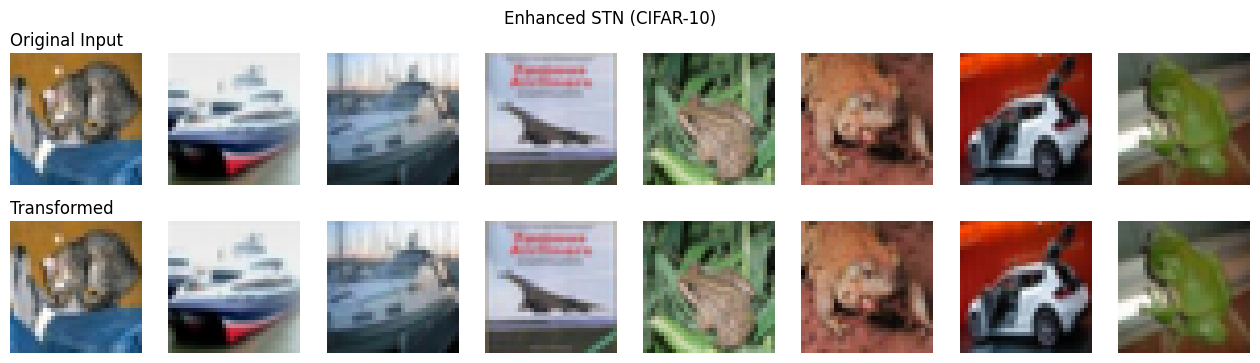


Visualizing Enhanced STN on SVHN...


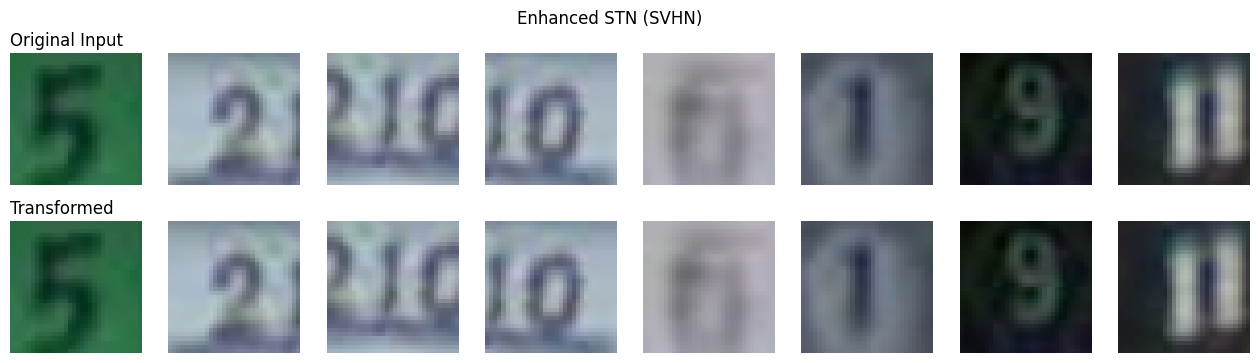

In [16]:
# ## 8. Visualization 

DATASET_STATS = {
    'cifar10': {
        'mean': (0.4914, 0.4822, 0.4465),
        'std': (0.2023, 0.1994, 0.2010)
    },
    'svhn': {
        'mean': (0.4377, 0.4438, 0.4728),
        'std': (0.1980, 0.2010, 0.1970)
    }
}

def visualize_stn(model, loader, device, dataset_name, title="STN Visualization"):
    model.eval()
    with torch.no_grad():
        data = next(iter(loader))[0].to(device)
        input_tensor = data[:8]
        if isinstance(model, nn.DataParallel):
            transformed_tensor, _ = model.module.stn(input_tensor)
        else:
            transformed_tensor, _ = model.stn(input_tensor)

    input_tensor = input_tensor.cpu()
    transformed_tensor = transformed_tensor.cpu()

    def unnormalize(tensor, mean, std):
        for t, m, s in zip(tensor, mean, std):
            t.mul_(s).add_(m)
        return tensor

    stats = DATASET_STATS.get(dataset_name.lower())
    if stats is None:
        mean, std = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
    else:
        mean, std = stats['mean'], stats['std']

    def imshow(img, ax):
        img = img.clone()
        img = unnormalize(img, mean, std)
        img = torch.clamp(img, 0, 1)
        npimg = img.numpy()
        ax.imshow(np.transpose(npimg, (1, 2, 0)))
        ax.axis('off')

    fig, axes = plt.subplots(2, 8, figsize=(16, 4))
    for i in range(8):
        imshow(input_tensor[i], axes[0, i])
        imshow(transformed_tensor[i], axes[1, i])

    axes[0, 0].set_title("Original Input", loc='left')
    axes[1, 0].set_title("Transformed", loc='left')
    plt.suptitle(title)
    plt.show()

print("\nVisualizing Enhanced STN on CIFAR-10...")
visualize_stn(model_enhanced_cifar, test_loader_aug, device, 'cifar10', "Enhanced STN (CIFAR-10)")

print("\nVisualizing Enhanced STN on SVHN...")
visualize_stn(model_enhanced_svhn, test_loader_s_aug, device, 'svhn', "Enhanced STN (SVHN)")

## 2. Model Definitions

### 2.1 Spatial Transformer Module (Shared)
This is the core STN module that can be attached to any network. 

To address the loss of spatial information caused by aggressive pooling in small images (e.g., 32x32), we improved the localization network architecture. Instead of flattening the features directly after multiple pooling layers, we utilize **Global Average Pooling (GAP)**. This approach helps the network capture global context without losing critical localization cues and reduces the risk of overfitting by minimizing the number of parameters in the regressor.

In [3]:
class SpatialTransformer(nn.Module):
    def __init__(self, input_channels=3, input_size=32, hidden_dim=32):
        super(SpatialTransformer, self).__init__()

        # Localization Network
        self.localization = nn.Sequential(
            # Layer 1: 32x32 -> 16x16
            nn.Conv2d(input_channels, hidden_dim, kernel_size=7, padding=3),
            nn.BatchNorm2d(hidden_dim),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            
            # Layer 2: 16x16 -> 8x8
            nn.Conv2d(hidden_dim, hidden_dim*2, kernel_size=5, padding=2),
            nn.BatchNorm2d(hidden_dim*2),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            
            # Layer 3: 8x8 -> 8x8 (Pooling 제거하여 공간 정보 유지)
            nn.Conv2d(hidden_dim*2, hidden_dim*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_dim*4),
            nn.ReLU(True)
            # 여기서는 MaxPool을 쓰지 않습니다.
        )

        # [변경] Global Average Pooling (GAP) 도입
        # 어떤 입력 크기가 들어와도 (C, 1, 1)로 만들어 파라미터 수를 획기적으로 줄이고 유연성을 확보합니다.
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        # GAP를 거치면 (Batch, Channels, 1, 1)이 되므로
        # 입력 차원은 채널 수(hidden_dim * 4)와 같습니다.
        loc_out_size = hidden_dim * 4

        # Regressor for affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(loc_out_size, 128),
            nn.ReLU(True),
            nn.Linear(128, 6)
        )

        # Initialize with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    def forward(self, x):
        x = x.contiguous()

        xs = self.localization(x)
        
        # [변경] GAP 적용 및 Flatten
        xs = self.gap(xs)
        xs = xs.view(xs.size(0), -1) 
        
        theta = self.fc_loc(xs)

        theta = theta.contiguous().view(-1, 2, 3)

        # Grid generator
        grid = F.affine_grid(theta, x.size(), align_corners=False)

        # Sampler
        x_transformed = F.grid_sample(x, grid, align_corners=False)

        return x_transformed, theta

### 2.2 Baseline STN Model
A simple custom CNN attached to the STN.

In [4]:
class BaselineSTN(nn.Module):
    def __init__(self, num_classes=10):
        super(BaselineSTN, self).__init__()
        self.stn = SpatialTransformer(input_channels=3, input_size=32)
        
        # Simple CNN Classifier
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x, theta = self.stn(x)
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x, theta

### 2.3 Improved STN Model (ResNet Backbone)
Uses a ResNet-18 backbone (modified for 32x32 images) as the classifier. This represents a "modern" deep learning approach.

In [5]:
class ImprovedSTN(nn.Module):
    def __init__(self, num_classes=10):
        super(ImprovedSTN, self).__init__()
        # Improved STN localization network (slightly wider)
        self.stn = SpatialTransformer(input_channels=3, input_size=32, hidden_dim=64)
        
        # Use ResNet18 as the classifier
        # We modify the first layer because CIFAR/SVHN are 32x32, not 224x224
        self.backbone = models.resnet18(pretrained=False)
        self.backbone.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.backbone.maxpool = nn.Identity() # Skip maxpool to preserve spatial dim for small images
        self.backbone.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x, theta = self.stn(x)
        x = self.backbone(x)
        return x, theta

## 3. Training Engine

We implement a flexible training loop that supports:
- Identity Transformation Regularization: Adds a penalty term to the loss function to keep the STN transformation close to the identity matrix early in training, improving stability
- Schedulers: Cosine Annealing for better convergence
- Gradient Clipping: Prevents exploding gradients
- Automatic device handling: Seamlessly supports CPU/GPU

In [6]:
def train_model(model, train_loader, test_loader, config, device):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()

    # Optimizer
    if config['optimizer'] == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=config['lr'])
    elif config['optimizer'] == 'adamw':
        optimizer = optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=1e-4)

    # Scheduler
    if config.get('scheduler') == 'cosine':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['epochs'])
    else:
        scheduler = None
        
    # [NEW] Identity Transformation 목표값 정의 ([1, 0, 0, 0, 1, 0])
    # 이 텐서는 학습 내내 고정되므로 미리 정의합니다.
    identity_target = torch.tensor([1.0, 0.0, 0.0, 0.0, 1.0, 0.0], device=device)
    lambda_reg = 0.1  # Regularization 강도 (실험에 따라 조절 가능)

    history = {'train_acc': [], 'test_acc': [], 'train_loss': []}

    start_time = time.time()

    for epoch in range(config['epochs']):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['epochs']}", leave=False)
        for inputs, labels in pbar:
            inputs = inputs.to(device, non_blocking=True).contiguous()
            labels = labels.to(device, non_blocking=True)

            optimizer.zero_grad()
            
            outputs, theta = model(inputs)
            
            loss_cls = criterion(outputs, labels)
            
            theta_flat = theta.view(-1, 6)
            target = identity_target.expand_as(theta_flat)
            loss_reg = F.mse_loss(theta_flat, target)
            
            loss = loss_cls + (lambda_reg * loss_reg)

            loss.backward()

            # Gradient clipping
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        if scheduler:
            scheduler.step()

        train_acc = 100. * correct / total
        train_loss = running_loss / len(train_loader)

        # Evaluation
        model.eval()
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device, non_blocking=True).contiguous()
                labels = labels.to(device, non_blocking=True)
                # 테스트 시에는 theta가 필요 없으므로 무시
                outputs, _ = model(inputs)
                _, predicted = outputs.max(1)
                test_total += labels.size(0)
                test_correct += predicted.eq(labels).sum().item()

        test_acc = 100. * test_correct / test_total

        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)
        history['train_loss'].append(train_loss)

        print(f"Epoch {epoch+1} | Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")

    print(f"Total time: {time.time() - start_time:.2f}s")
    return history

## 4. Experiments

### 4.1 Experiment 1: CIFAR-10 Comparison

In [7]:
print("="*60)
print("RUNNING CIFAR-10 EXPERIMENTS")
print("="*60)

# 1. Baseline Run
print("\n[CIFAR-10] Training Baseline STN...")
train_loader, test_loader, num_classes = get_dataloaders('cifar10', batch_size=128, use_augmentation=False)
baseline_config = {'epochs': 15, 'lr': 0.001, 'optimizer': 'adam', 'scheduler': None}

model_baseline_cifar = BaselineSTN(num_classes).to(device)
if torch.cuda.device_count() > 1: model_baseline_cifar = nn.DataParallel(model_baseline_cifar)
hist_baseline_cifar = train_model(model_baseline_cifar, train_loader, test_loader, baseline_config, device)

# 2. Improved Run
print("\n[CIFAR-10] Training Improved STN (ResNet + Augmentation + AdamW)...")
train_loader_aug, test_loader_aug, _ = get_dataloaders('cifar10', batch_size=128, use_augmentation=True)
improved_config = {'epochs': 15, 'lr': 0.001, 'optimizer': 'adamw', 'scheduler': 'cosine'}

model_improved_cifar = ImprovedSTN(num_classes).to(device)
if torch.cuda.device_count() > 1: model_improved_cifar = nn.DataParallel(model_improved_cifar)
hist_improved_cifar = train_model(model_improved_cifar, train_loader_aug, test_loader_aug, improved_config, device)

RUNNING CIFAR-10 EXPERIMENTS

[CIFAR-10] Training Baseline STN...


100%|██████████| 170M/170M [00:01<00:00, 94.1MB/s] 


Epoch 1 | Loss: 1.5054 | Train Acc: 45.67% | Test Acc: 55.26%


Epoch 2 | Loss: 1.1034 | Train Acc: 60.97% | Test Acc: 64.05%


Epoch 3 | Loss: 0.9168 | Train Acc: 67.87% | Test Acc: 66.74%


Epoch 4 | Loss: 0.8074 | Train Acc: 71.79% | Test Acc: 70.22%


Epoch 5 | Loss: 0.7255 | Train Acc: 74.71% | Test Acc: 72.27%


Epoch 6 | Loss: 0.6531 | Train Acc: 77.25% | Test Acc: 73.44%


Epoch 7 | Loss: 0.5959 | Train Acc: 79.08% | Test Acc: 73.64%


Epoch 8 | Loss: 0.5416 | Train Acc: 81.19% | Test Acc: 74.62%


Epoch 9 | Loss: 0.4916 | Train Acc: 82.80% | Test Acc: 74.90%


Epoch 10 | Loss: 0.4438 | Train Acc: 84.30% | Test Acc: 73.52%


Epoch 11 | Loss: 0.4057 | Train Acc: 85.74% | Test Acc: 75.39%


Epoch 12 | Loss: 0.3638 | Train Acc: 87.18% | Test Acc: 74.84%


Epoch 13 | Loss: 0.3190 | Train Acc: 88.80% | Test Acc: 74.52%


Epoch 14 | Loss: 0.2836 | Train Acc: 90.04% | Test Acc: 74.48%


Epoch 15 | Loss: 0.2522 | Train Acc: 91.05% | Test Acc: 74.63%
Total time: 204.59s

[CIFAR-10] Training Improved STN (ResNet + Augmentation + AdamW)...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1 | Loss: 1.4160 | Train Acc: 48.02% | Test Acc: 57.03%


Epoch 2 | Loss: 1.0081 | Train Acc: 64.13% | Test Acc: 65.22%


Epoch 3 | Loss: 0.8207 | Train Acc: 71.09% | Test Acc: 66.07%


Epoch 4 | Loss: 0.7099 | Train Acc: 74.97% | Test Acc: 77.28%


Epoch 5 | Loss: 0.6146 | Train Acc: 78.58% | Test Acc: 78.15%


Epoch 6 | Loss: 0.5501 | Train Acc: 80.87% | Test Acc: 81.07%


Epoch 7 | Loss: 0.4942 | Train Acc: 82.77% | Test Acc: 82.26%


Epoch 8 | Loss: 0.4466 | Train Acc: 84.59% | Test Acc: 84.64%


Epoch 9 | Loss: 0.3970 | Train Acc: 86.31% | Test Acc: 86.65%


Epoch 10 | Loss: 0.3617 | Train Acc: 87.23% | Test Acc: 87.85%


Epoch 11 | Loss: 0.3291 | Train Acc: 88.48% | Test Acc: 87.87%


Epoch 12 | Loss: 0.2933 | Train Acc: 89.81% | Test Acc: 89.41%


Epoch 13 | Loss: 0.2674 | Train Acc: 90.64% | Test Acc: 89.69%


Epoch 14 | Loss: 0.2510 | Train Acc: 91.15% | Test Acc: 89.95%


Epoch 15 | Loss: 0.2422 | Train Acc: 91.55% | Test Acc: 89.99%
Total time: 706.03s


### 4.2 Experiment 2: SVHN Comparison

In [8]:
print("\n" + "="*60)
print("RUNNING SVHN EXPERIMENTS")
print("="*60)

# 1. Baseline Run
print("\n[SVHN] Training Baseline STN...")
train_loader_s, test_loader_s, num_classes_s = get_dataloaders('svhn', batch_size=128, use_augmentation=False)
baseline_config = {'epochs': 10, 'lr': 0.001, 'optimizer': 'adam', 'scheduler': None}

model_baseline_svhn = BaselineSTN(num_classes_s).to(device)
if torch.cuda.device_count() > 1: model_baseline_svhn = nn.DataParallel(model_baseline_svhn)
hist_baseline_svhn = train_model(model_baseline_svhn, train_loader_s, test_loader_s, baseline_config, device)

# 2. Improved Run
print("\n[SVHN] Training Improved STN (ResNet + Augmentation + AdamW)...")
train_loader_s_aug, test_loader_s_aug, _ = get_dataloaders('svhn', batch_size=128, use_augmentation=True)
improved_config = {'epochs': 10, 'lr': 0.001, 'optimizer': 'adamw', 'scheduler': 'cosine'}

model_improved_svhn = ImprovedSTN(num_classes_s).to(device)
if torch.cuda.device_count() > 1: model_improved_svhn = nn.DataParallel(model_improved_svhn)
hist_improved_svhn = train_model(model_improved_svhn, train_loader_s_aug, test_loader_s_aug, improved_config, device)


RUNNING SVHN EXPERIMENTS

[SVHN] Training Baseline STN...


100%|██████████| 182M/182M [00:22<00:00, 8.19MB/s] 
100%|██████████| 64.3M/64.3M [00:12<00:00, 5.08MB/s]


Epoch 1 | Loss: 1.0152 | Train Acc: 67.02% | Test Acc: 83.44%


Epoch 2 | Loss: 0.4412 | Train Acc: 87.27% | Test Acc: 86.75%


Epoch 3 | Loss: 0.3590 | Train Acc: 89.62% | Test Acc: 88.93%


Epoch 4 | Loss: 0.3080 | Train Acc: 90.92% | Test Acc: 89.35%


Epoch 5 | Loss: 0.2760 | Train Acc: 91.98% | Test Acc: 89.54%


Epoch 6 | Loss: 0.2485 | Train Acc: 92.78% | Test Acc: 90.30%


Epoch 7 | Loss: 0.2255 | Train Acc: 93.42% | Test Acc: 90.58%


Epoch 8 | Loss: 0.2086 | Train Acc: 94.04% | Test Acc: 90.48%


Epoch 9 | Loss: 0.1913 | Train Acc: 94.46% | Test Acc: 90.46%


Epoch 10 | Loss: 0.1774 | Train Acc: 94.86% | Test Acc: 90.24%
Total time: 219.08s

[SVHN] Training Improved STN (ResNet + Augmentation + AdamW)...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1 | Loss: 0.7391 | Train Acc: 75.83% | Test Acc: 89.75%


Epoch 2 | Loss: 0.3404 | Train Acc: 89.75% | Test Acc: 92.46%


Epoch 3 | Loss: 0.2817 | Train Acc: 91.61% | Test Acc: 93.75%


Epoch 4 | Loss: 0.2438 | Train Acc: 92.88% | Test Acc: 95.15%


Epoch 5 | Loss: 0.2179 | Train Acc: 93.59% | Test Acc: 94.98%


Epoch 6 | Loss: 0.1914 | Train Acc: 94.41% | Test Acc: 95.89%


Epoch 7 | Loss: 0.1693 | Train Acc: 95.13% | Test Acc: 95.62%


Epoch 8 | Loss: 0.1497 | Train Acc: 95.75% | Test Acc: 96.35%


Epoch 9 | Loss: 0.1344 | Train Acc: 96.16% | Test Acc: 96.49%


Epoch 10 | Loss: 0.1253 | Train Acc: 96.57% | Test Acc: 96.54%
Total time: 727.36s


## 5. Visual Comparisons

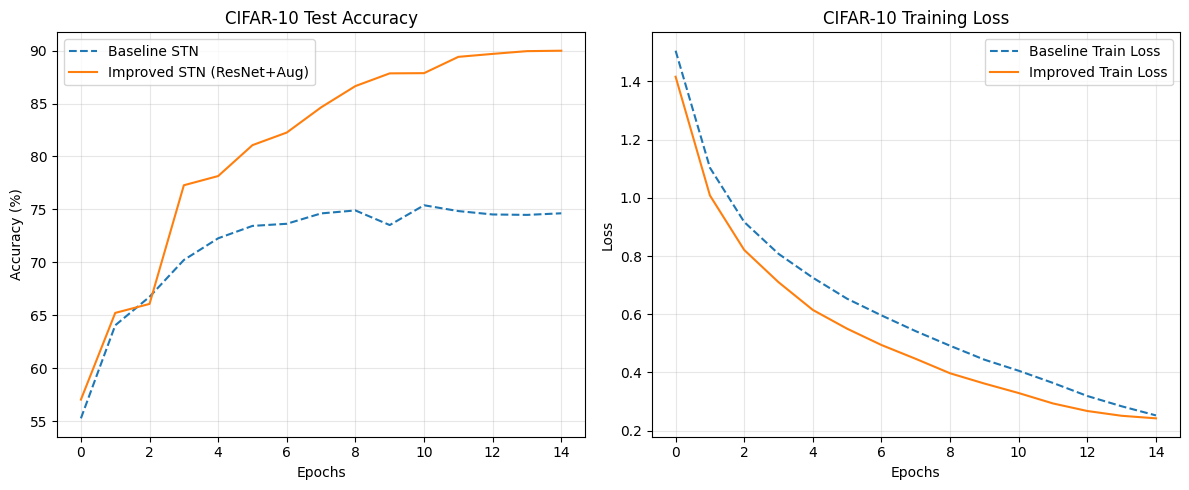

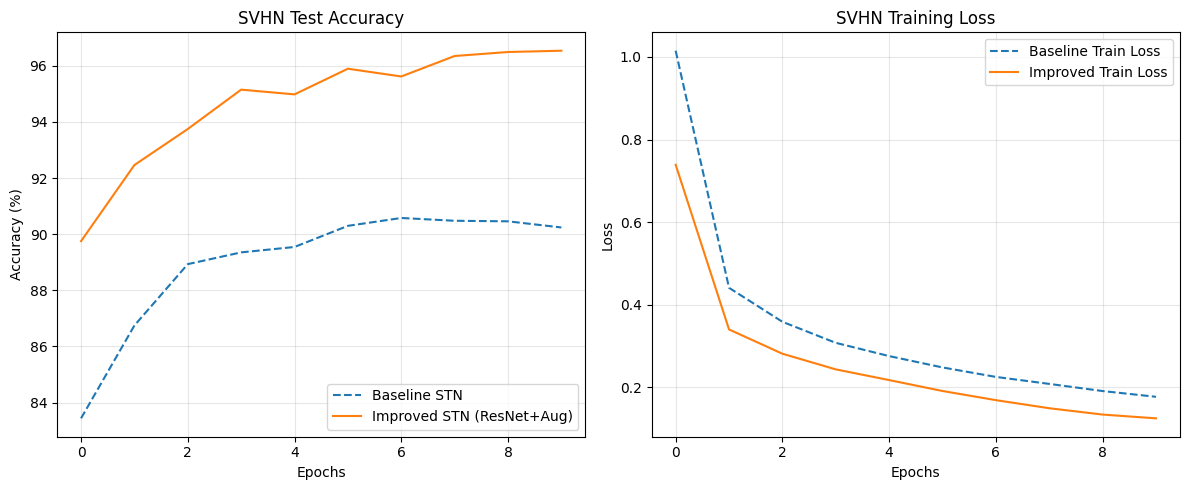

In [9]:
def plot_comparison(baseline_hist, improved_hist, dataset_name):
    plt.figure(figsize=(12, 5))
    
    # Accuracy Comparison
    plt.subplot(1, 2, 1)
    plt.plot(baseline_hist['test_acc'], label='Baseline STN', linestyle='--')
    plt.plot(improved_hist['test_acc'], label='Improved STN (ResNet+Aug)')
    plt.title(f'{dataset_name} Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Loss Comparison
    plt.subplot(1, 2, 2)
    plt.plot(baseline_hist['train_loss'], label='Baseline Train Loss', linestyle='--')
    plt.plot(improved_hist['train_loss'], label='Improved Train Loss')
    plt.title(f'{dataset_name} Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'{dataset_name}_comparison.png')
    plt.show()

plot_comparison(hist_baseline_cifar, hist_improved_cifar, 'CIFAR-10')
plot_comparison(hist_baseline_svhn, hist_improved_svhn, 'SVHN')

Visualizing CIFAR-10 Baseline STN...


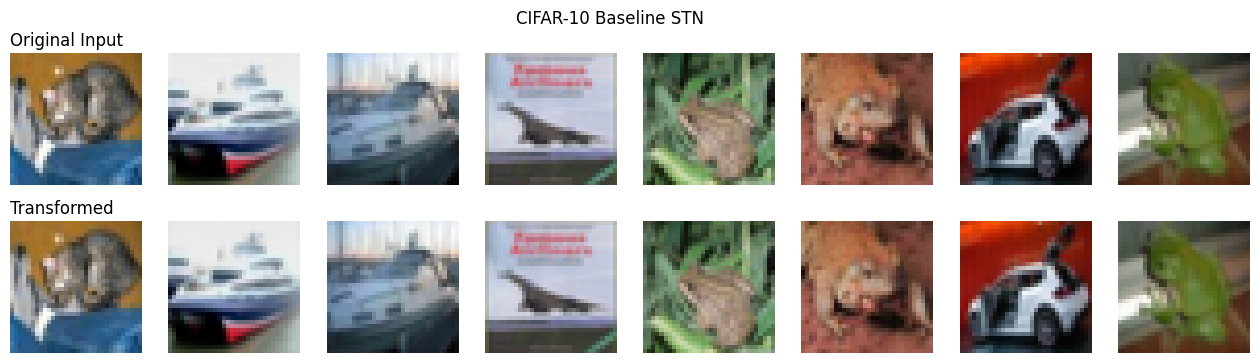

Visualizing CIFAR-10 Improved STN...


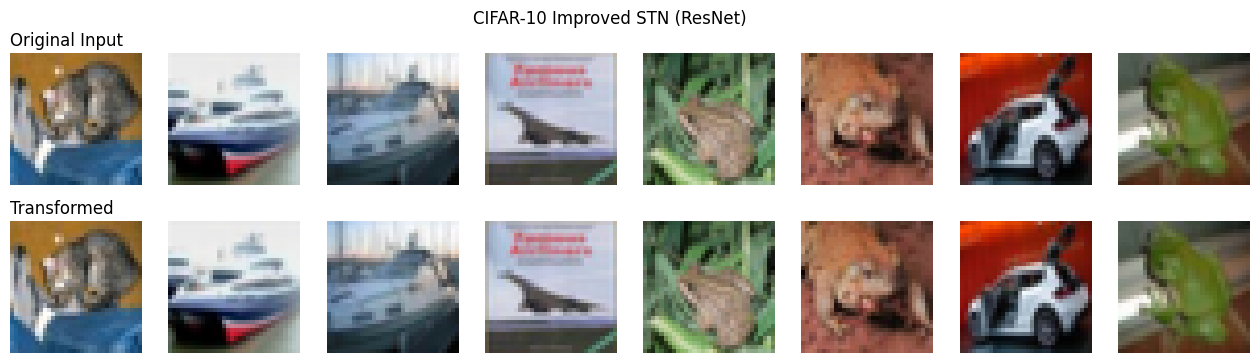

In [27]:
DATASET_STATS = {
    'cifar10': {
        'mean': (0.4914, 0.4822, 0.4465),
        'std': (0.2023, 0.1994, 0.2010)
    },
    'svhn': {
        'mean': (0.4377, 0.4438, 0.4728),
        'std': (0.1980, 0.2010, 0.1970)
    }
}

# [변경] dataset_name 인자를 추가하여 정확한 복원을 수행
def visualize_stn(model, loader, device, dataset_name, title="STN Visualization"):
    model.eval()
    with torch.no_grad():
        data = next(iter(loader))[0].to(device)
        input_tensor = data[:8]
        # DataParallel 체크 로직 유지
        if isinstance(model, nn.DataParallel):
            transformed_tensor, _ = model.module.stn(input_tensor)
        else:
            transformed_tensor, _ = model.stn(input_tensor)

    input_tensor = input_tensor.cpu()
    transformed_tensor = transformed_tensor.cpu()

    # [핵심 변경] 정확한 Un-normalization 함수
    def unnormalize(tensor, mean, std):
        # tensor: (C, H, W)
        # mean, std: (3,)
        for t, m, s in zip(tensor, mean, std):
            t.mul_(s).add_(m) # In-place operation: val * std + mean
        return tensor

    # 해당 데이터셋의 통계값 가져오기
    stats = DATASET_STATS.get(dataset_name.lower())
    if stats is None:
        print(f"Warning: No stats found for {dataset_name}, using default.")
        mean, std = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
    else:
        mean, std = stats['mean'], stats['std']

    def imshow(img, ax):
        # 복사본을 만들어 원본 텐서 보존 (In-place 연산 때문)
        img = img.clone()
        img = unnormalize(img, mean, std)
        
        # Clip to [0, 1] to avoid matplotlib warnings
        img = torch.clamp(img, 0, 1)
        
        npimg = img.numpy()
        ax.imshow(np.transpose(npimg, (1, 2, 0)))
        ax.axis('off')

    fig, axes = plt.subplots(2, 8, figsize=(16, 4))
    for i in range(8):
        imshow(input_tensor[i], axes[0, i])
        imshow(transformed_tensor[i], axes[1, i])

    axes[0, 0].set_title("Original Input", loc='left')
    axes[1, 0].set_title("Transformed", loc='left')
    plt.suptitle(title)
    plt.show()

# [호출부 수정] dataset_name 인자('cifar10' 등)를 명시적으로 전달해야 합니다.
print("Visualizing CIFAR-10 Baseline STN...")
visualize_stn(model_baseline_cifar, test_loader, device, 'cifar10', "CIFAR-10 Baseline STN")

print("Visualizing CIFAR-10 Improved STN...")
visualize_stn(model_improved_cifar, test_loader_aug, device, 'cifar10', "CIFAR-10 Improved STN (ResNet)")